In [1]:
import numpy as np
from math import pi
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.fft as fft
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import scipy
import scipy.io as sio
from scipy import ndimage
import tifffile
from misc import show_imset, circular_aper, ZernikeBasis, mask_resize_reshape
import PIL
from model_utils import LensModel, Dataset, calculate_cc, calculate_cc_v2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


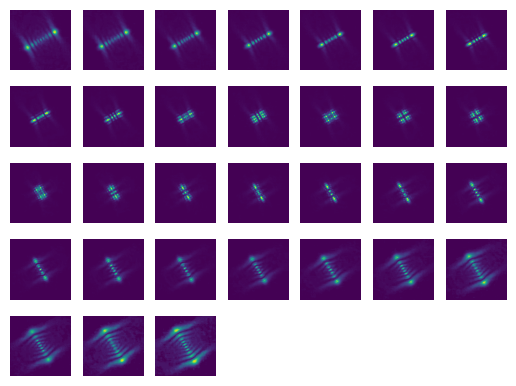

size of the detection mask: 512, half width of PSFs: 75


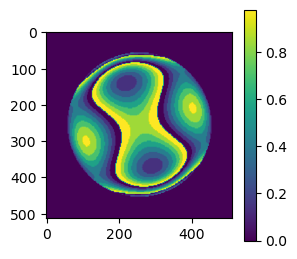

In [2]:
# the first zstack for model detection
zstack = tifffile.imread('.//data//tp_561_-10_1_20.tif')
photons = 1e4
zstack1 = zstack/np.sum(zstack, axis=(1, 2), keepdims=True)*photons
dzos1 = np.linspace(-10e-3, 20e-3, 31)
show_imset(zstack1)
# the corresponding phase mask
mat_dict = sio.loadmat('.//data//580_1full_D_5p24mm_pixel_size_13p333um.mat')
hmap1 = mat_dict[list(mat_dict.keys())[3]]
N_hmap1 = hmap1.shape[0]
ps_mask1 = 13.33e-6 # pixel size of the mask
N_aper1 = 394 # pixel number of mask aperture
dn1 = 0.4595  # ri_silica - ri_air, wavelength: 561nm
w05_1 = int(zstack1.shape[1]/2)  # half width of the image
print(f'size of the detection mask: {N_hmap1}, half width of PSFs: {w05_1}')
plt.figure(figsize=(3, 3))
ax = plt.imshow(hmap1)
plt.colorbar(ax)
plt.show()

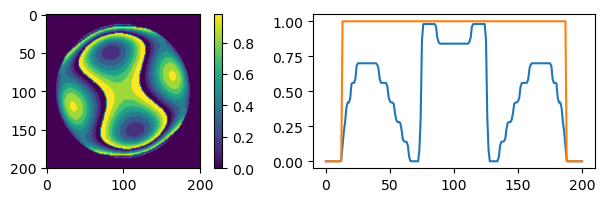

In [3]:
# aperture setting
ps_aper = 30e-6
N = 201  # simulation size at the mask plane
idx05 = int(np.floor(N/2))
lamda = 561e-9
k = 2*pi/lamda

# resize
hmap1_re = mask_resize_reshape(hmap1, ps_mask1/ps_aper, N) # resize the height map
phase1 = k*hmap1_re*1e-6*dn1

N_aper = int(np.round(N_aper1*ps_mask1/ps_aper))  # aperture
aper = circular_aper(N, N_aper/N)

zernike = ZernikeBasis(N_aper)
znms = zernike.polynomials(3)  # up to order 3
znms = znms[1:] # ignore z00
before = int((N-N_aper)/2)
after = N-N_aper-before
znms = np.pad(znms, ((0, 0), (before, after), (before, after)))
idx_defocus = 3

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
ax = plt.imshow(hmap1_re)
plt.colorbar(ax)
plt.subplot(1, 2, 2)
plt.plot(np.arange(N), hmap1_re[idx05, :])
plt.plot(np.arange(N), aper[idx05, :])
plt.show()

In [4]:
model_dict=dict()
model_dict['N'] = N
model_dict['M'] = 1.0  # magnification
model_dict['lamda'] = lamda
model_dict['ps_aper'] = ps_aper
model_dict['ps_psf'] = 4.3e-6  # cannon rebel ti2
model_dict['N_aper'] = N_aper
model_dict['device'] = device
model_dict['w05'] = w05_1
model_dict['mask_phase'] = torch.tensor(phase1).to(device)
model_dict['aper'] = torch.tensor(aper).to(device)
model_dict['znms'] = torch.tensor(znms).to(device)
model_dict['idx_defocus'] = idx_defocus
model_dict['photons'] = photons


In [5]:
xyzs = np.concatenate((np.zeros((dzos1.shape[0], 2)), dzos1[:, np.newaxis]), axis=1)
xyzs1 = torch.tensor(xyzs).to(device).type(torch.float32)
psf_gt1 = torch.tensor(zstack1).to(device).type(torch.float32)

dataset = Dataset(xyzs1, psf_gt1)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

seed = 11 # 11 22
torch.manual_seed(seed)
np.random.seed(seed)

model = LensModel(model_dict)
model.to(device)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params':model.parameters(), 'lr':1e-2},
                              {'params':model.scale_factor, 'lr':1e-2},
                              {'params':model.rotation_theta, 'lr':1e-2},
                              {'params':model.sigma, 'lr':1e-2},
                             ],
                             betas=(0.96,0.999),
                            )


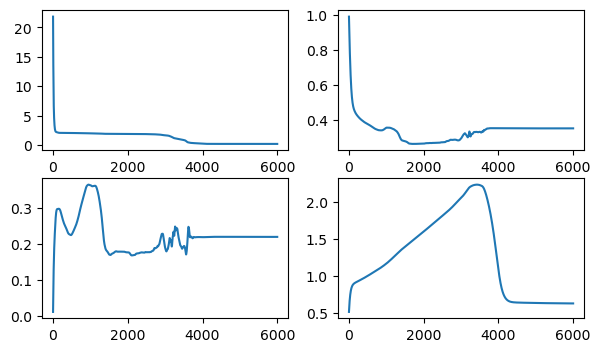

In [6]:
# recording_flag = False
epoch_num1 = 6000

epoch_loss = []
scale_in_loop = []
rotation_in_loop = []
sigma_in_loop = []

for epoch in range(epoch_num1):
    batch_loss = []
    for xbatch, ybatch in dataloader:
        psf = model(xbatch)
        loss = loss_func(psf[:, 0, :, :], ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
    
    epoch_loss.append(sum(batch_loss)/len(batch_loss))
    scale_in_loop.append(model.scale_factor.detach().item())
    rotation_in_loop.append(model.rotation_theta.detach().item())
    sigma_in_loop.append(model.sigma.detach().item())


plt.figure(figsize=(7, 4))
plt.subplot(2, 2, 1)
plt.plot(epoch_loss)

plt.subplot(2, 2, 2)
plt.plot(scale_in_loop)

plt.subplot(2, 2, 3)
plt.plot(rotation_in_loop)
plt.subplot(2, 2, 4)
plt.plot(sigma_in_loop)
plt.show()

mean cc: 0.96437427073857


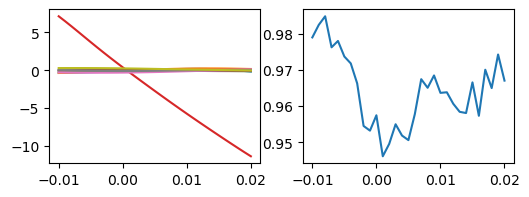

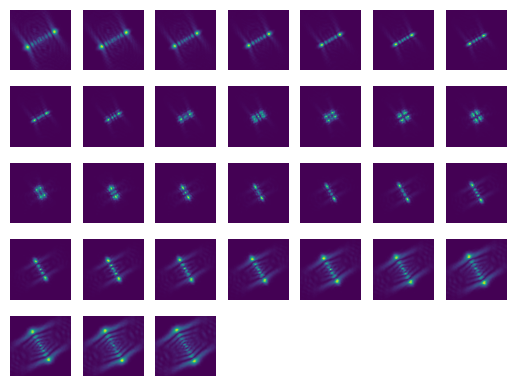

In [7]:
with torch.set_grad_enabled(False):
    zc = model.z2zc(xyzs1[:, 2:3])
    psf = model(xyzs1)
    
psf = psf.cpu().numpy()[:, 0, :, :]    
psf1 = psf/np.sum(psf, axis=(1, 2), keepdims=True)*1e4
ccs1 = calculate_cc(psf1, zstack1)
print(f'mean cc: {np.mean(ccs1)}')
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(dzos1, zc.cpu())
plt.subplot(1, 2, 2)
plt.plot(dzos1, ccs1)
plt.show()
show_imset(psf1)
   

In [8]:
model.mask_phase = torch.zeros_like(model.mask_phase)
model.mask_phase.requires_grad_(True)
optimizer = torch.optim.Adam([{'params':model.mask_phase, 'lr':1e-2}])

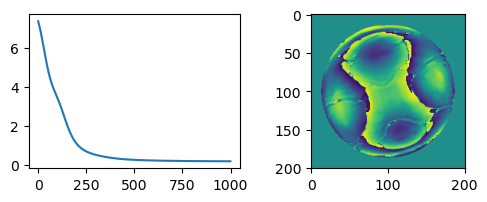

In [9]:
epoch_num2 = 1000

for epoch in range(epoch_num2):
    batch_loss = []
    for xbatch, ybatch in dataloader:
        psf = model(xbatch)
        loss = loss_func(psf[:, 0, :, :], ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
    
    epoch_loss.append(sum(batch_loss)/len(batch_loss))
    scale_in_loop.append(model.scale_factor.detach().item())
    rotation_in_loop.append(model.rotation_theta.detach().item())
    sigma_in_loop.append(model.sigma.detach().item())

    
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss[-epoch_num2:])
plt.subplot(1, 2, 2)
mask1 = model.mask_phase.detach().cpu().numpy()
mask1 = np.angle(np.exp(1j*mask1))
plt.imshow(mask1)
plt.show()

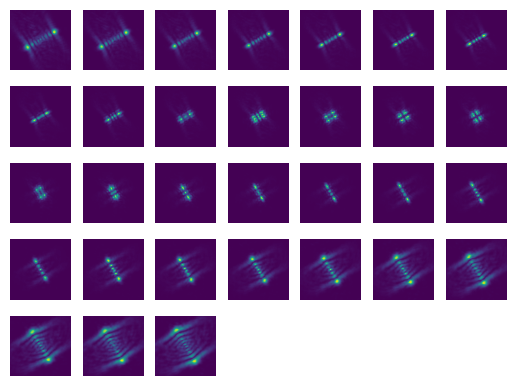

mean cc: 0.9672904436710196


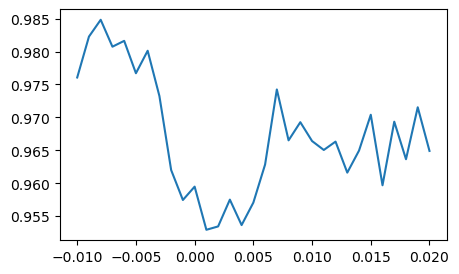

In [10]:
with torch.set_grad_enabled(False):
    psf = model(xyzs1)
psf = psf.cpu().numpy()[:, 0, :, :]
psf1 = psf/np.sum(psf, axis=(1, 2), keepdims=True)*1e4
show_imset(psf1)
# calculate cc
ccs1 = calculate_cc(psf1, zstack1)
print(f'mean cc: {np.mean(ccs1)}')
plt.figure(figsize=(5, 3))
plt.plot(dzos1, ccs1)
plt.show()

In [11]:
optimizer = torch.optim.Adam([{'params':model.parameters(), 'lr':1e-2},
                              {'params':model.scale_factor, 'lr':1e-2},
                              {'params':model.rotation_theta, 'lr':1e-2},
                              {'params':model.sigma, 'lr':1e-2},
                             ],
                             betas=(0.96,0.999),
                            )

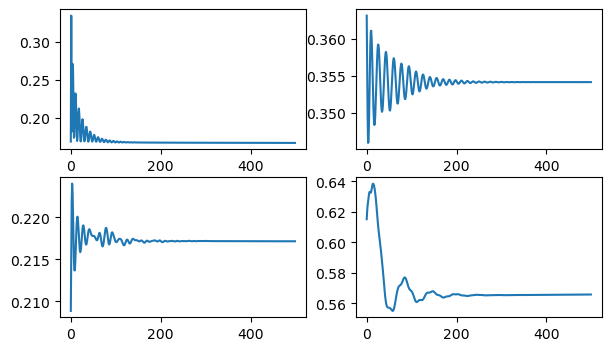

In [12]:
epoch_num3 = 500

for epoch in range(epoch_num3):
    batch_loss = []
    for xbatch, ybatch in dataloader:
        psf = model(xbatch)
        loss = loss_func(psf[:, 0, :, :], ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
    
    epoch_loss.append(sum(batch_loss)/len(batch_loss))
    scale_in_loop.append(model.scale_factor.detach().item())
    rotation_in_loop.append(model.rotation_theta.detach().item())
    sigma_in_loop.append(model.sigma.detach().item())



plt.figure(figsize=(7, 4))
plt.subplot(2, 2, 1)
plt.plot(epoch_loss[-epoch_num3:])
plt.subplot(2, 2, 2)
plt.plot(scale_in_loop[-epoch_num3:])
plt.subplot(2, 2, 3)
plt.plot(rotation_in_loop[-epoch_num3:])
plt.subplot(2, 2, 4)
plt.plot(sigma_in_loop[-epoch_num3:])
plt.show()

mean cc: 0.9676869284413281


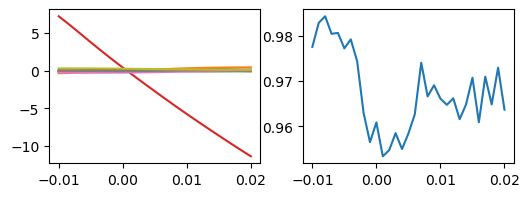

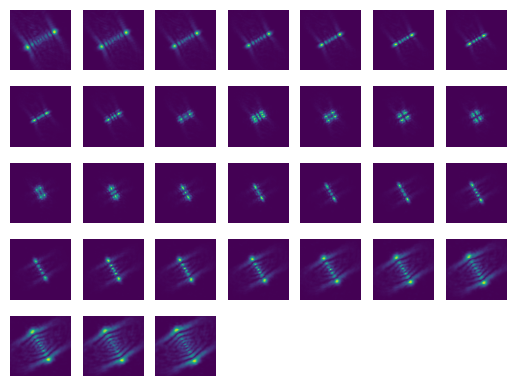

In [13]:
with torch.set_grad_enabled(False):
    zc = model.z2zc(xyzs1[:, 2:3])
    psf = model(xyzs1)
    
psf = psf.cpu().numpy()[:, 0, :, :]    
psf1 = psf/np.sum(psf, axis=(1, 2), keepdims=True)*1e4
ccs1 = calculate_cc(psf1, zstack1)
print(f'mean cc: {np.mean(ccs1)}')
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(dzos1, zc.cpu())
plt.subplot(1, 2, 2)
plt.plot(dzos1, ccs1)
plt.show()
show_imset(psf1)

In [14]:
model.update()
optimizer = torch.optim.Adam([{'params':model.mask_phase2, 'lr':1e-2}])

new simulation size: 567


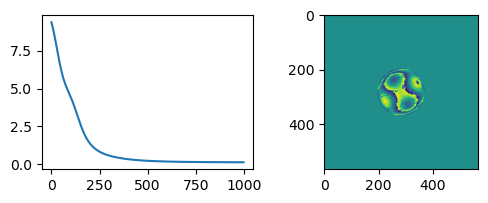

In [15]:
epoch_num4 = 1000
# mask2_in_loop = []
for epoch in range(epoch_num4):
    batch_loss = []
    for xbatch, ybatch in dataloader:
        psf = model.apply(xbatch)
        loss = loss_func(psf[:, 0, :, :], ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
    
    epoch_loss.append(sum(batch_loss)/len(batch_loss))


plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss[-epoch_num4:])
plt.subplot(1, 2, 2)
mask2 = model.mask_phase2.detach().cpu().numpy()
mask2 = np.angle(np.exp(1j*mask2))
plt.imshow(mask2)
plt.show()

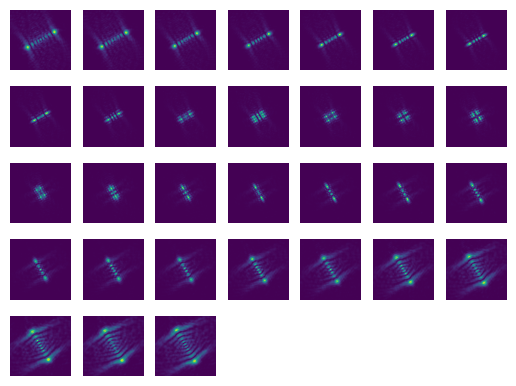

mean cc: 0.9761026907645265


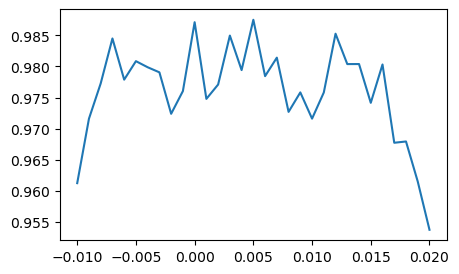

In [16]:
with torch.set_grad_enabled(False):
    psf = model.apply(xyzs1)
psf = psf.cpu().numpy()[:, 0, :, :]
psf1 = psf/np.sum(psf, axis=(1, 2), keepdims=True)*1e4
show_imset(psf1)
# calculate cc
ccs1 = calculate_cc_v2(psf1, zstack1)
print(f'mean cc: {np.mean(ccs1)}')
plt.figure(figsize=(5, 3))
plt.plot(dzos1, ccs1)
plt.show()

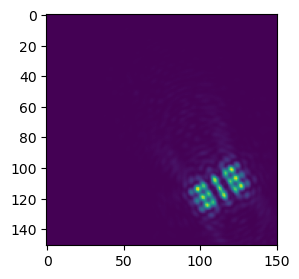

In [17]:
# try the final version of the model 
with torch.set_grad_enabled(False):
    x = model.ps_psf*model.w05/2
    y = model.ps_psf*model.w05/2
    z = 0.0
    point_xyz = torch.tensor([[x, y, z]], device=device)
    psf = model.apply(point_xyz)
    psf = psf.cpu().numpy()[:, 0, :, :]
    plt.figure(figsize=(3, 3))
    plt.imshow(psf[0,: ,:])
    plt.show()

In [18]:
# save the established model: 1-z2zc, 2-others
# z2zc = model.z2zc
# for parameter in z2zc.parameters():
#     parameter.requires_grad = False
#     parameter.cpu()

# checkpoint = {'z2zc': nn.Sequential(nn.Linear(1, 6), nn.Sigmoid(), nn.Linear(6, 6), nn.Sigmoid(), nn.Linear(6, model.znms.shape[0])),
#               'z2zc_state_dict': z2zc.state_dict(),
#               'znms': model.znms2.cpu(),
#               'xgrid': model.xgrid.cpu(),
#               'ygrid': model.ygrid.cpu(),
#               'aper': model.aper2.cpu(),
#               'mask': model.mask_phase2.detach().cpu(),
#               'blur_kernel': model.blur_kernel().detach().cpu(),
              
#               'ps_aper': model.ps_aper,
#               'ps_psf': model.ps_psf,
#               'N': model.N2,
#               'N_aper': model.N_aper,
#               'idx_defocus': model.idx_defocus,
#              }

# torch.save(checkpoint, 'checkpoint0911.pt')

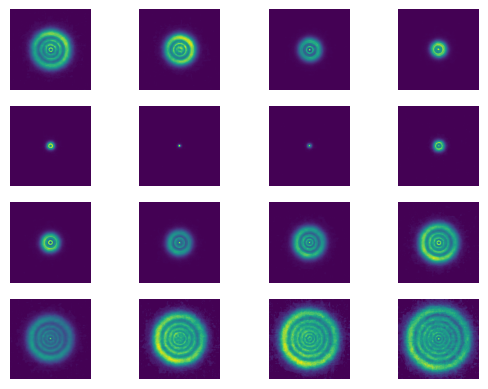

half width of PSFs: 90


In [19]:
# the second zstack for model test
zstack = tifffile.imread('.//data//st_561_-10_2_20.tif')
zstack[5, :, :-1] = zstack[5, :, 1:]  # to compensate for PSF centering issue
zstack[6, :, :-1] = zstack[6, :, 1:]  # to compensate for PSF centering issue

zstack2 = zstack/np.sum(zstack, axis=(1, 2), keepdims=True)*1e4 
dzos2 = np.linspace(-10e-3, 20e-3, 16) 
show_imset(zstack2)
w05_2 = int(zstack2.shape[1]/2)  # half width of the image
print(f'half width of PSFs: {w05_2}')


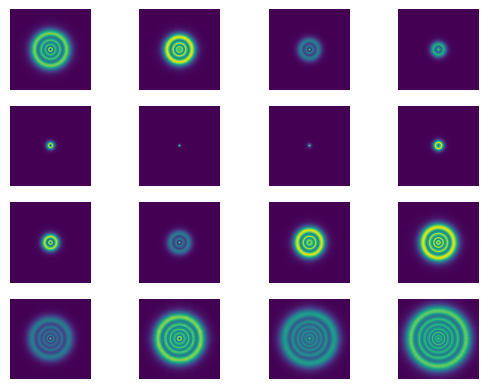

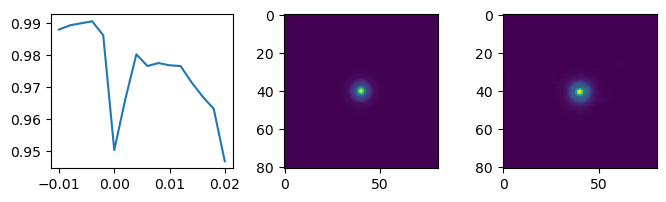

In [20]:
xyzs = np.concatenate((np.zeros((dzos2.shape[0], 2)), dzos2[:, np.newaxis]), axis=1)
xyzs2 = torch.tensor(xyzs).to(device).type(torch.float32)
phase2 = model.aper2
with torch.set_grad_enabled(False):
    model.w05 = w05_2
    model.zernike_defocus_only=True  # only switch on zernike defocus 
    psf = model.apply(xyzs2, phase2)
    
psf2 = psf.cpu().numpy()[:, 0, :, :]  
psf2 = psf2/np.sum(psf2, axis=(1, 2), keepdims=True)*1e4
show_imset(psf2)
# calculate cc
# ccs2 = calculate_cc(psf2, zstack2)
ccs2 = calculate_cc_v2(psf2, zstack2)
plt.figure(figsize=(8, 2))
plt.subplot(1, 3, 1)
plt.plot(dzos2, ccs2)
plt.subplot(1, 3, 2)
plt.imshow(psf2[6, 50:-50, 50:-50])
plt.subplot(1, 3, 3)
plt.imshow(zstack2[6, 50:-50, 50:-50])
plt.show()


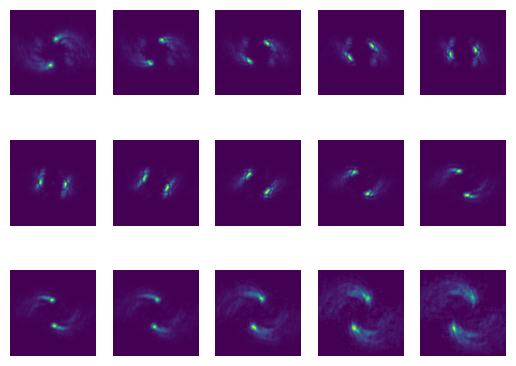

size of the test mask: 143, half width of PSFs: 90


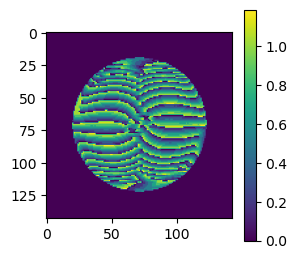

In [21]:
# double helix mask
zstack = tifffile.imread('.//data//dh_561_-10_2_20.tif')
zstack4 = zstack/np.sum(zstack, axis=(1, 2), keepdims=True)*1e4 
dzos4 = np.linspace(-10e-3, 20e-3, 16)
zstack4 = zstack4[:-1]
dzos4 = dzos4[:-1]

show_imset(zstack4)

# the corresponding phase mask
# mat_dict = sio.loadmat('.//tokina_data//DH525_8mm.mat')
mat_dict = sio.loadmat('.//data//dh_8mm.mat')
hmap4 = mat_dict[list(mat_dict.keys())[3]]
hmap4 = np.fliplr(hmap4)
N_hmap4 = hmap4.shape[0]
ps_mask4 = 78.3752e-6 # pixel size of the mask
N_aper4 = 103 # pixel number of mask aperture
dn4 = 0.4595  # ri_silica - ri_air, wavelength: 561nm
w05_4 = int(zstack4.shape[1]/2)  # half width of the image
print(f'size of the test mask: {N_hmap4}, half width of PSFs: {w05_4}')
plt.figure(figsize=(3, 3))
ax = plt.imshow(hmap4)
plt.colorbar(ax)
plt.show()

In [22]:
def mask_resize_reshape(mask, resize_factor, final_shape):
    # resize
    im = PIL.Image.fromarray(mask)
    N_resize = int(np.round(mask.shape[0]*resize_factor))
    mask1 = np.array(im.resize([N_resize, N_resize], PIL.Image.Resampling.NEAREST))  # resized mask
    if final_shape>=N_resize:
        # zero padding
        before = int((final_shape-N_resize)/2)
        after = final_shape-N_resize-before
        mask2 = np.pad(mask1, (before, after))
    else:
        # crop
        before = int((N_resize-final_shape)/2)
        mask2 = mask1[before:before+final_shape, before:before+final_shape]
        
    return mask2

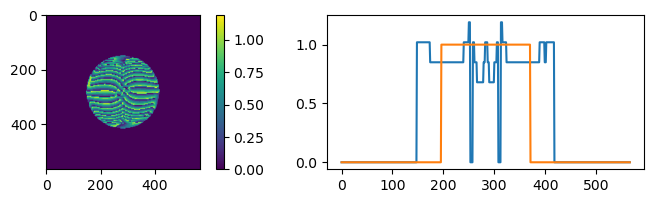

In [23]:
# resize
N2 = model.N2
idx05_2 = model.idx05_2
hmap4_re = mask_resize_reshape(hmap4, ps_mask4/ps_aper, N2) # resize the height map

# N_aper4_re = int(np.round(N_aper4*ps_mask4/ps_aper))  # aperture resize

phase4 = k*hmap4_re*1e-6*dn4
# aper4 = circular_aper(N2, N_aper4_re/N2)
aper4 = model.aper2.cpu().numpy()

plt.figure(figsize=(9, 2))
plt.subplot(1, 2, 1)
ax = plt.imshow(hmap4_re)
plt.colorbar(ax)
plt.subplot(1, 2, 2)
plt.plot(np.arange(N2), hmap4_re[idx05_2, :])
plt.plot(np.arange(N2), aper4[idx05_2, :])
plt.show()

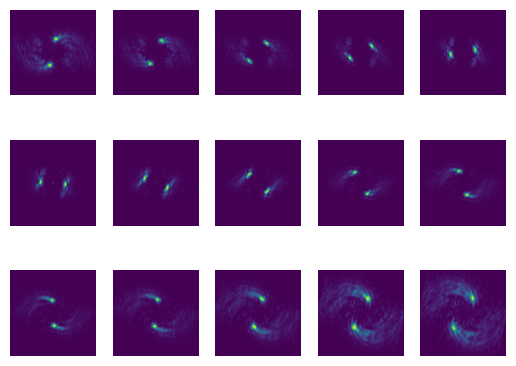

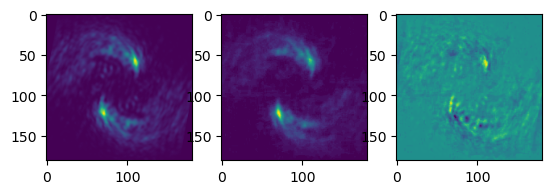

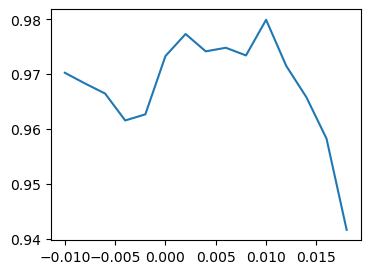

In [24]:
xyzs = np.concatenate((np.zeros((dzos4.shape[0], 2)), dzos4[:, np.newaxis]), axis=1)
xyzs4 = torch.tensor(xyzs).to(device).type(torch.float32)

with torch.set_grad_enabled(False):
    # model.aper2 = torch.tensor(aper4).to(device)
    model.w05 = w05_4
    model.zernike_defocus_only=True
    psf = model.apply(xyzs4, torch.tensor(phase4).to(device))
    
    # PSF rotation
    theta = torch.tensor(1.39, device=device)
    at_m = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0.0],
                        [torch.sin(theta), torch.cos(theta), 0.0],
                        [0.0, 0.0, 1.0]])
    at_m = at_m.unsqueeze(0).repeat(psf.shape[0], 1, 1).to(device)
    grid = F.affine_grid(at_m[:, :2, :], psf.size(), align_corners=True)
    psf = F.grid_sample(psf, grid, align_corners=True)
    
    
    psf = psf.cpu().numpy()[:, 0, :, :]

psf4 = psf/np.sum(psf, axis=(1, 2), keepdims=True)*1e4
show_imset(psf4)

idx=-1
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(psf4[idx, :, :])
plt.subplot(1, 3, 2)
plt.imshow(zstack4[idx, :, :])
plt.subplot(1, 3, 3)
plt.imshow(psf4[idx, :, :]-zstack4[idx, :, :])
plt.show()

ccs4 = calculate_cc_v2(psf4, zstack4)

plt.figure(figsize=(4, 3))
plt.plot(dzos4, ccs4)
plt.show()

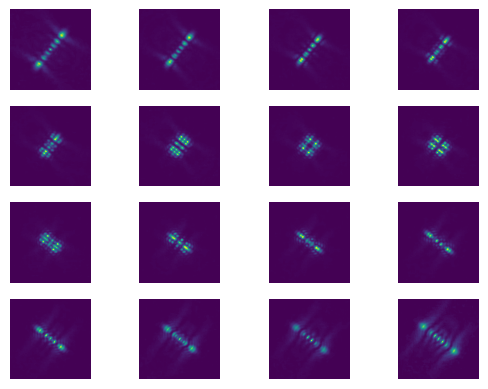

size of the test mask: 551, half width of PSFs: 75


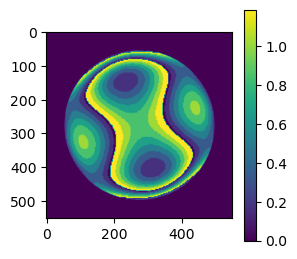

In [25]:
# the first zstack for model detection
zstack = tifffile.imread('.//data//tp_561_-10_1_20_test.tif')
zstack3 = zstack/np.sum(zstack, axis=(1, 2), keepdims=True)*1e4 
dzos3 = np.linspace(-10e-3, 20e-3, 16)
show_imset(zstack3)
# the corresponding phase mask
mat_dict = sio.loadmat('.//data//w605_d467_fused_quartz.mat')
hmap3 = mat_dict[list(mat_dict.keys())[5]]
N_hmap3 = hmap3.shape[0]
ps_mask3 = 10e-6 # pixel size of the mask
N_aper3 = 443 # pixel number of mask aperture
dn3 = 0.4595  # ri_silica - ri_air, wavelength: 561nm
w05_3 = int(zstack3.shape[1]/2)  # half width of the image
print(f'size of the test mask: {N_hmap3}, half width of PSFs: {w05_3}')
plt.figure(figsize=(3, 3))
ax = plt.imshow(hmap3)
plt.colorbar(ax)
plt.show()


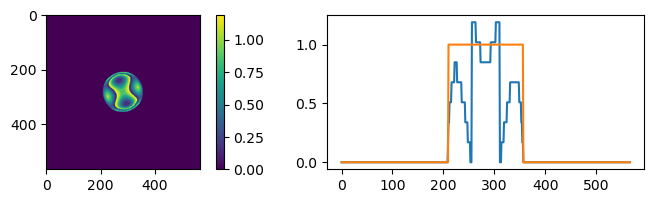

In [26]:
# resize
N2 = model.N2
idx05_2 = model.idx05_2
hmap3_re = mask_resize_reshape(hmap3, ps_mask3/ps_aper, N2) # resize the height map
N_aper3_re = int(np.round(N_aper3*ps_mask3/ps_aper))  # aperture resize

phase3 = k*hmap3_re*1e-6*dn3
aper3 = circular_aper(N2, N_aper3_re/N2)

plt.figure(figsize=(9, 2))
plt.subplot(1, 2, 1)
ax = plt.imshow(hmap3_re)
plt.colorbar(ax)
plt.subplot(1, 2, 2)
plt.plot(np.arange(N2), hmap3_re[idx05_2, :])
plt.plot(np.arange(N2), aper3[idx05_2, :])
plt.show()

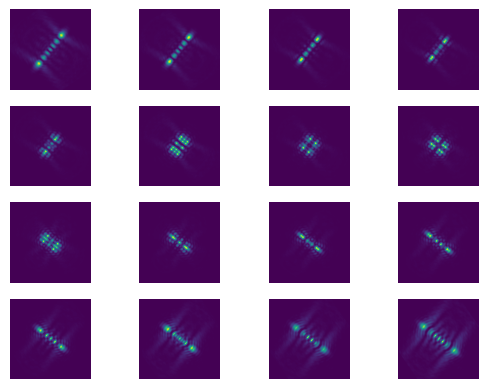

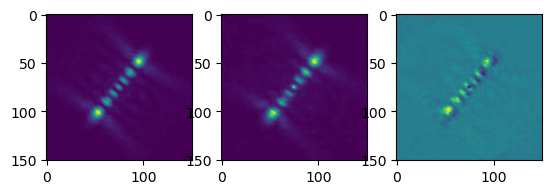

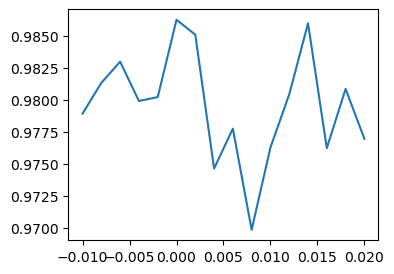

In [27]:
xyzs = np.concatenate((np.zeros((dzos3.shape[0], 2)), dzos3[:, np.newaxis]), axis=1)
xyzs3 = torch.tensor(xyzs).to(device).type(torch.float32)

with torch.set_grad_enabled(False):
    model.aper2 = torch.tensor(aper3).to(device)
    model.w05 = w05_3
    model.zernike_defocus_only=True # 
    psf = model.apply(xyzs3, torch.tensor(phase3).to(device))
    
    # PSF rotation
    theta = torch.tensor(0.60, device=device)
    at_m = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0.0],
                        [torch.sin(theta), torch.cos(theta), 0.0],
                        [0.0, 0.0, 1.0]])
    at_m = at_m.unsqueeze(0).repeat(psf.shape[0], 1, 1).to(device)
    grid = F.affine_grid(at_m[:, :2, :], psf.size(), align_corners=True)
    psf = F.grid_sample(psf, grid, align_corners=True)
    
    
    psf = psf.cpu().numpy()[:, 0, :, :]

psf3 = psf/np.sum(psf, axis=(1, 2), keepdims=True)*1e4
show_imset(psf3)

plt.figure()
idx=0
plt.subplot(1, 3, 1)
plt.imshow(psf3[idx, :, :])
plt.subplot(1, 3, 2)
plt.imshow(zstack3[idx, :, :])
plt.subplot(1, 3, 3)
plt.imshow(psf3[idx, :, :]-zstack3[idx, :, :])
plt.show()

ccs3 = calculate_cc_v2(psf3, zstack3)
plt.figure(figsize=(4, 3))
plt.plot(dzos3, ccs3)
plt.show()